# Executive Summary

# Introduction

The purpose of this study is to build a linear regression model that will predict the number of covid-19 cases for any Toronto neighborhood based on its demographic data. Predicting covid-19 cases is useful in that an understanding of which socioeconomic factors that influence the growth of disease in a community will help with our understanding of the virus. This knowledge will enable resources to be better targeted in the future to help prevent transmission during this, or any future pandemic.

### Load Libraries

In [971]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
%matplotlib inline
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

## Data

A population Census is held across Canada every 5 years. It collects data about age and sex, families and households, language, immigration and internal migration, racial diversity, Aboriginal peoples, housing, education, income, and labor. 
The City of Toronto Neighborhood Profiles use this Census data to provide a portrait of the demographic, social and economic characteristics of the people and households in each City of Toronto neighborhood.



The data is made available through Toronto's Open Data portal (https://open.toronto.ca/).

Two datasets from this site were used for this study. One that shows the number of covid cases by Toronto neighborhood (https://open.toronto.ca/dataset/covid-19-cases-in-toronto/) and the other contains demographic features of each of these neighborhoods (https://open.toronto.ca/dataset/neighbourhood-profiles/). There are over 2,300 features show for each neighborhood including:

### Load Files

In [972]:
covid_to = pd.read_csv('data/CityofToronto_COVID-19_NeighbourhoodData.csv')

In [973]:
neigh = pd.read_csv("data/neighbourhood-profiles-2016-csv_ADJ.csv")

### Data Cleaning

The demographic data is a huge dataset containing over 2300 rows, each one representing a different demographic feature. In order to create one usable dataset the following tasks were performed:

1. The dataset was transposed so that the columns, which are the Toronto neighborhoods become row and each feature becomes a column.
2. Every column is given a unique identifying name.
3. A dataframe was created to capture the column descriptions which are quite lengthy.
4. Null rows were dropped - these were summary rows which did not relate to each neighborhood.
5. All the numeric columns were converted to floats - there were no categorical columns.
6. The two dataframes (demographic data and covid case data) were merged on the neighborhood id column to create one dataframe.

In [974]:
# The Neighbourhood file has Neighbourhoods as columns so we must 
# transpose it.
neighTO = neigh.transpose()

There are over 2300 columns. Let's keep track of the names meanings of these columns so we can 
later use this information to interpret the results. In the meantime we will refer to the columns by
their numeric names.

In [975]:
# Let's the column names to strings
neighTO.columns = ["Col_" + str(x) for x in neighTO.columns]

In [976]:
colNames = neighTO.iloc[0:5,:].transpose()

In [977]:
# Now we have a dataframe of all the column names
colNames.head(5).iloc[:,0:5]

,_id,Category,Topic,Special,Characteristic
Col_0,1,Neighbourhood Information,Neighbourhood Information,NaN,Neighbourhood Number
Col_1,1,Neighbourhood Information,Neighbourhood Information,NaN,Neighbourhood Number
Col_2,3,Population,Population and dwellings,X,"Population, 2016"
Col_3,4,Population,Population and dwellings,NaN,"Population, 2011"
Col_4,6,Population,Population and dwellings,NaN,Total private dwellings


In [978]:
# Let's remove all the descriptive rows
neighTO = neighTO.iloc[5:,:]

In [979]:
# We can remove the city of Toronto
neighTO = neighTO[neighTO.index != 'City of Toronto']

In [980]:
# Let's ensure the neighborhoodID in both files is an int so we can
# join the files
neighTO['Col_0'] = neighTO['Col_0'].astype(int)

In [981]:
# We drop the null row and convert ID to int
covid_to.dropna(inplace=True)
covid_to['Neighbourhood ID'] = covid_to['Neighbourhood ID'].astype(int)

In [982]:
# Let's convert the demographic data to floats - select only string columns
for x in neighTO.select_dtypes(include='object').columns:
    if x != 'Col_0':
        # Remove % symbol if present
        neighTO[x] = neighTO[x].replace({'%':''}, regex = True)
        neighTO[x] = neighTO[x].astype(float)

In [983]:
# We see they are all floats except for the int column
neighTO.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, Agincourt North to Yorkdale-Glen Park
Columns: 2306 entries, Col_0 to Col_2305
dtypes: float64(2305), int64(1)
memory usage: 2.5+ MB


In [984]:
# Now we can see that all our columns are numeric
neighTO.describe().iloc[:,1:5]

,Col_1,Col_2,Col_3,Col_4
count,140.000000,140.000000,140.000000,140.000000
mean,0.434000,19511.221429,96.683000,42.818071
std,0.319835,10033.589222,6.728256,8.067717
min,0.000000,6577.000000,65.790000,29.450000
25%,0.185000,12019.500000,95.925000,37.540000
50%,0.360000,16749.500000,98.550000,40.930000
75%,0.630000,23854.500000,100.347500,45.862500
max,1.700000,65913.000000,108.220000,71.620000


We need to join the datasets so we have one dataset with all the features and target.

In [985]:
# Rename the column so they match in both files
neighTO.rename(columns={'Col_0': "Neighbourhood ID"}, inplace=True)

In [986]:
# Join the files on Neighbourhood ID
NeighCases = pd.merge(neighTO, covid_to, how='left', on=['Neighbourhood ID'])

In [987]:
# Let's write this to excel to back it up.
NeighCases.to_csv("data/NeigCases.csv")

## Data Exploration

There's a huge difference in the rate of covid-19 cases in each Toronto neighborhood. 

The top 5 neighborhoods **dramatically higher case rates** than the bottom five neighborhoods (Figure 1).

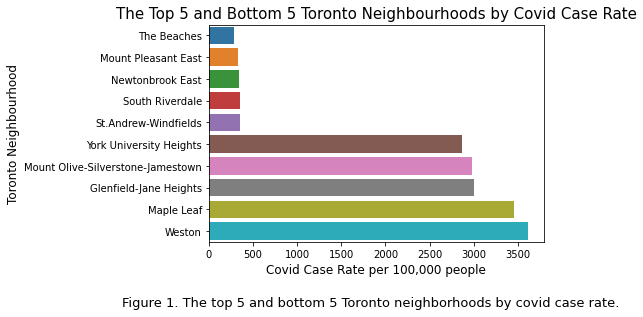

In [989]:
sns.reset_orig()
df = NeighCases[['Neighbourhood Name', "Rate per 100,000 people"]].sort_values("Rate per 100,000 people")
df.columns = ['Neighbourhood', 'Rate per 100,000 people']

ax = sns.barplot(data=df.head(5).append(df.tail(5)), y='Neighbourhood',x='Rate per 100,000 people',orient='h')
txt="Figure 1. The top 5 and bottom 5 Toronto neighborhoods by covid case rate."
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=13)

plt.title('The Top 5 and Bottom 5 Toronto Neighbourhoods by Covid Case Rate',fontsize= 15)
plt.xlabel("Covid Case Rate per 100,000 people", fontsize=12)
plt.ylabel("Toronto Neighbourhood", fontsize=12);

The rate in the neighborhood of Weston has a covid case rate of almost 13 times that of the Beaches neighborhood.

In [990]:
df.head(1).append(df.tail(1))

,Neighbourhood,"Rate per 100,000 people"
116,The Beaches,282.839523
126,Weston,3612.716763


Various media reports have shown that certain demographic factors can influence covid rates. Reports have shown that the virus has disproportionately affected communities based on the following factors:


* Racial Profile<br>
* Density<br>
* Employment<br>
* Income<br>

Let's examine some columns that correspond to these factors and see how they relate to covid rate.

In [991]:
colNames.Category.unique()

array(['Neighbourhood Information', 'Population',
       'Families, households and marital status', 'Language', 'Income',
       'Immigration and citizenship', 'Visible minority', 'Ethnic origin',
       'Aboriginal peoples', 'Education', 'Housing', 'Language of work',
       'Labour', 'Journey to work', 'Mobility'], dtype=object)

Figure 2 shows the how covid rates vary depending on the proportion of different racial groups in each Toronto neighborhood. 

There seems to be a moderate positive relationship between covid rates and the percent of Blacks in each neighborhood and also Latin Americans.

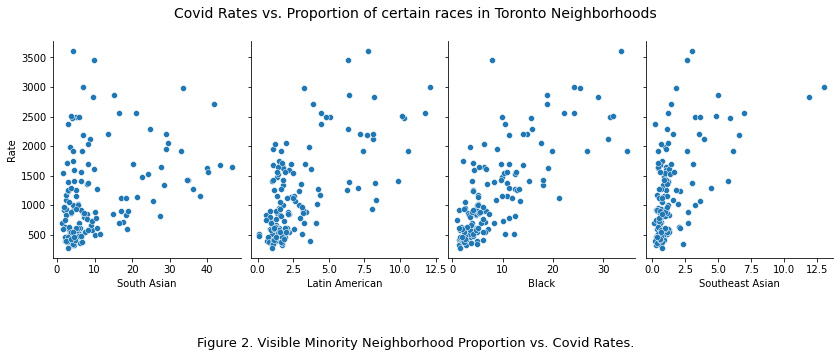

In [992]:
# Let's look at the top 5 visible minority categories
df = NeighCases[colNames[colNames['Category'] == 'Visible minority'].index]
df = df.rename(columns={"Col_1266": "Visible Minority", "Col_1267": "South Asian",
                  "Col_1077": "Latin American", "Col_1269": "Black", "Col_1272": "Southeast Asian"})
df['Rate'] = NeighCases['Rate per 100,000 people']
df = df[["South Asian", "Latin American", "Black", "Southeast Asian","Rate"]]
# Create the pairplot
ax = sns.pairplot(data=df, 
            x_vars=["South Asian", "Latin American", "Black", "Southeast Asian"],
            y_vars=['Rate'], diag_kind=None);
# Add titles
ax.fig.suptitle("Covid Rates vs. Proportion of certain races in Toronto Neighborhoods", y=1.08, fontsize=14) # y= some height>1
txt="Figure 2. Visible Minority Neighborhood Proportion vs. Covid Rates."
# plt.title("The proportion of selected visible minority groups in Toronto neighborhoods vs. Covid Rates", loc="left");
# Set the size
ax.fig.set_size_inches(12,4)
# Add the figure text below
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=13);

Now lets check some other potential predictors, including income, density and employment.

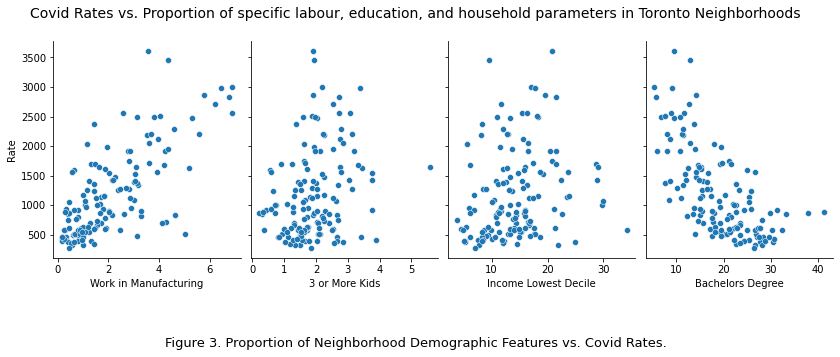

In [993]:
# Let's look at the top 5 visible minority categories
df = NeighCases[["Col_1855", "Col_100", "Col_1047", "Col_1635"]]
df = df.rename(columns={"Col_1855": "Work in Manufacturing", "Col_100": "3 or More Kids",\
                        "Col_1047": "Income Lowest Decile", "Col_1635": "Bachelors Degree"})

df['Rate'] = NeighCases['Rate per 100,000 people']
# df = df[["South Asian", "Latin American", "Black", "Southeast Asian","Rate"]]
# Create the pairplot
ax = sns.pairplot(data=df, 
            x_vars=["Work in Manufacturing", "3 or More Kids",\
                    "Income Lowest Decile", "Bachelors Degree"],
            y_vars=['Rate'], diag_kind=None);
# Add titles
ax.fig.suptitle("Covid Rates vs. Proportion of specific labour, education, and household parameters in Toronto Neighborhoods", y=1.08, fontsize=14) # y= some height>1
txt="Figure 3. Proportion of Neighborhood Demographic Features vs. Covid Rates."
# plt.title("The proportion of selected visible minority groups in Toronto neighborhoods vs. Covid Rates", loc="left");
# Set the size
ax.fig.set_size_inches(12,4)
# Add the figure text below
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=13);

There seems to be a positive trend between the proportion of the population that work in manufacturing jobs in a neighborhood vs. covid rates, and a negative trend between the proportion who have Bachelor's Degrees (Figure 3).

## Feature Selection

There are so many features (over 2,300) so in order to narrow it down we will examine the correlation of every feature to the target (Covid rate per 100,000 people). We will select the top 100 of based on this correlation and use this as our new pared down dataset.

In [995]:
# Let's look at all the features and how they compare to 
# the target - this will show the top 100 features
cor = NeighCases.corr()
threshold = 0.6
a=abs(cor['Rate per 100,000 people'])
result=pd.DataFrame(a[a>0.6])
feat_cor = result.sort_values('Rate per 100,000 people', ascending=False).head(100)

In [996]:
# Let's remove the Case Count column and examine these variables
feat_cor.drop('Case Count', inplace=True)
# feat_cor.drop('Rate per 100,000 people', inplace=True)

In [1001]:
try:
    feat_cor.reset_index(level=0, inplace=True)
except:
    None

In [1005]:
try:
    colNames.reset_index(level=0, inplace=True)
except:
    None

In [1006]:
dfCol = colNames[['index','Category', 'Characteristic']]

In [1007]:
feat_corName = pd.merge(feat_cor, dfCol, how='left', on=['index'])

The top 10 features in order of descending correlation to "Rate per 100,000" column. The top features are all seemingly related to Black, Caribbean and African origins except for a Labor related column which is Occupations in manufacturing and utilities.

In [1011]:
# Here are the top 10 features in order of desending correlation to "Rate per 100,000"
feat_corName.sort_values(by='Rate per 100,000 people', ascending=False).head(10)

,level_0,index,"Rate per 100,000 people",Category,Characteristic
0,0,"Rate per 100,000 people",1.000000,NaN,NaN
1,1,Col_1269,0.744447,Visible minority,Black
2,2,Col_1105,0.741047,Immigration and citizenship,Jamaica
3,3,Col_1099,0.737303,Immigration and citizenship,Americas
4,4,Col_1377,0.731488,Ethnic origin,Jamaican
5,5,Col_329,0.727007,Language,Niger-Congo languages
6,6,Col_1855,0.726108,Labour,9 Occupations in manufacturing and utilities
7,7,Col_1135,0.724949,Immigration and citizenship,Nigeria
8,8,Col_1414,0.713611,Ethnic origin,Central and West African origins
9,9,Col_1329,0.712460,Ethnic origin,Caribbean origins


Let's look at the top correlation in each Category of predictors. The category with the top correlated predictor is "Visible Minority" (**0.75**) and "Housing" is the category with the lowest correlated predictor (**0.63**).

In [191]:
# Return top from each category
groupMax = feat_corName.groupby(["Category"])
groupMax.max('Rate per 100,000 people')

,"Rate per 100,000 people"
Category,
Education,0.677432
Ethnic origin,0.731440
"Families, households and marital status",0.690976
Housing,0.630043
Immigration and citizenship,0.741155
Income,0.684938
Journey to work,0.666780
Labour,0.726118
Language,0.727272


It seems logical that predictors within the same category would be correlated, so let's find the top correlated predictor within each category.

In [1013]:
# *****
# Let's find the rows with the highest value for each category
idx = feat_corName.groupby(['Category'])['Rate per 100,000 people'].transform(max) == \
feat_corName['Rate per 100,000 people']
feat_corName[idx]

,level_0,index,"Rate per 100,000 people",Category,Characteristic
1,1,Col_1269,0.744447,Visible minority,Black
2,2,Col_1105,0.741047,Immigration and citizenship,Jamaica
4,4,Col_1377,0.731488,Ethnic origin,Jamaican
5,5,Col_329,0.727007,Language,Niger-Congo languages
6,6,Col_1855,0.726108,Labour,9 Occupations in manufacturing and utilities
14,14,Col_105,0.690762,"Families, households and marital status",3 or more children
16,16,Col_1049,0.684972,Income,In the third decile
19,19,Col_1635,0.677412,Education,Bachelor's degree
27,27,Col_1907,0.666669,Journey to work,Between 12 p.m. and 4:59 a.m.
74,74,Col_1594,0.629968,Housing,2 household maintainers


In [1025]:
# Let's create a dataframe using only these values and let's make the
# columns more readable.
NeighCovid = NeighCases[feat_corName[idx]['index']]
NeighCovid['Rate'] = NeighCases['Rate per 100,000 people']

In [1026]:
NeighCovid.columns = ['Black%', 'Jamaica%', 'Jamaican', 'CongoLang', 'ManufactJob', 'MoreThan2Kids',\
                      'ThirdDecIncome', 'BachelorDegree', 'WorkNights', 'BothMaintHouse', 'Rate']

### Remove Correlated Predictors

If certain features are highly correlated with other ones then there are redundant features and they can be removed to make the model more simple. The following heatmap shows that there are several highly correlated features, for example _Black_ with *Jamaica%*, *Jamaican*, *CongoLang* and *MoreThan2Kids*.

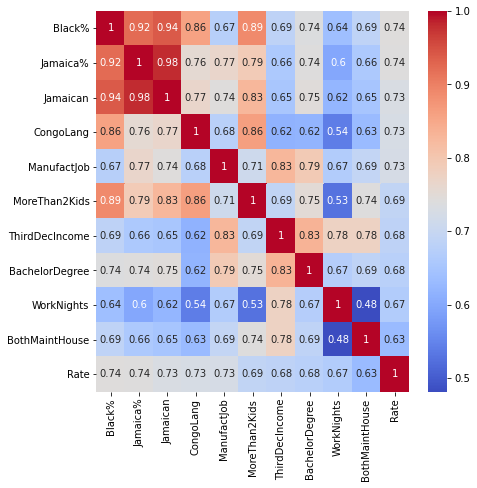

In [1027]:
# Correlation of variables
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

It makes sense than language, ethnic origin, language and visible minority categories of data
are highly correlated. Let's remove the *Jamaica%*, *Jamaican*, and *CongoLang* predictors.

In [1028]:
# Remove columns from dataset
NeighCovid.drop(['Jamaica%', 'Jamaican', 'CongoLang'], axis=1, inplace=True)

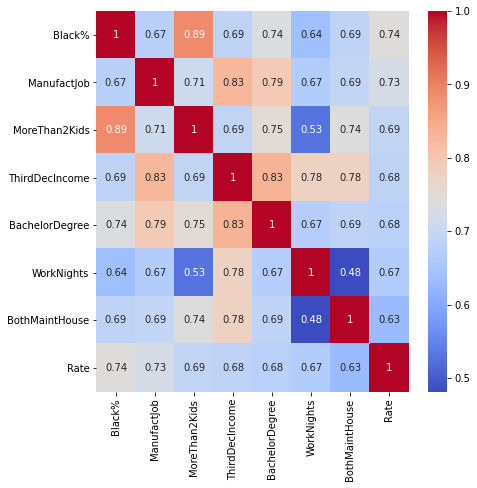

In [1029]:
# Check the heatmap again
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

In the interest of simplicity we can reduce features further. Black and Morethan2Kids is highly correlated, as well as ManufactJob and ThirdDecIncome so we will reduce the features that are least correlated with Rate.

In [1030]:
NeighCovid.drop(['MoreThan2Kids', 'ThirdDecIncome'], axis=1, inplace=True)

Let's look at the heatmap of feature correlations. We can now see that we have all the correlations are under **0.80**. Let's use these remaining features to build a model.

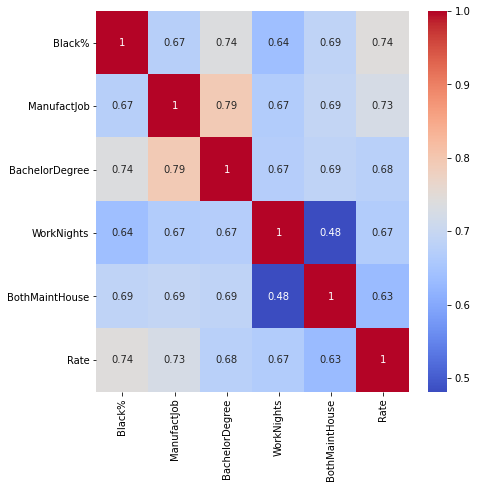

In [1031]:
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

## Results

### Linear Regression

#### Simple Linear Regression

Let's start with a simple linear regression model. We will use only one feature to predict the one target (Covid Rate). We will use the column which is most highly correlated to Covid Rate which is the percent of Black people in each neighborhood.

In [1036]:
# Create the X and y datasets
X = NeighCovid[["Black%"]]
y = NeighCovid["Rate"]

In [1037]:
# from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [1038]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

In [1039]:
# Create and train the model
from sklearn.linear_model import LinearRegression
#Create the model :
regressor = LinearRegression()
#Train the model :
regressor.fit(X_train, y_train)

LinearRegression()

Here's the coefficient of the model:

In [1047]:
L = regressor.coef_
L[0]

535.7894650023125

In [1042]:
# regressor.coef_
# coeff_X = pd.DataFrame(regressor.coef_, index = NeighCovid.columns[:-1], columns=['Coefficient'])
# coeff_X

array([535.789465])

Here is the intercept:

In [1048]:
regressor.intercept_

1217.1073039109747

In [1050]:
print("Rate = {:.2f} + {:.2f}*Black% ".format(regressor.intercept_,L[0]))

Rate = 1217.11 + 535.79*Black% 


In [1051]:
y_pred = regressor.predict(X_test)

Let's compare the actual vs. predicted values. They don't appear to be that close.

In [1053]:
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_results.head(10)

,Actual,Predicted
97,1050.743209,778.804244
116,282.839523,720.168045
46,554.900465,1067.746475
100,1064.519115,1565.094471
51,1280.614695,1483.851545
29,477.299185,894.663720
69,461.163450,718.755125
94,462.895993,775.978403
9,916.681012,703.213000
61,1530.105706,1485.970926


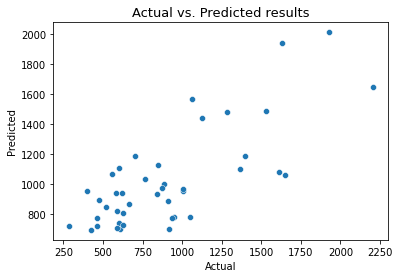

In [1057]:
# Let's examine a scatterplot of the actual vs. predicted values
sns.scatterplot(data=df_results, x = 'Actual', y = 'Predicted')
plt.title("Actual vs. Predicted results", fontsize=13);

Let's look at the results of the model. The **$R^2$ value is 0.49**. This is quite good for a social study such as this one. 

In [1058]:
from sklearn.metrics import mean_squared_error , r2_score

mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error:
root_mse = np.sqrt(mse)

#R_squared : 
R_squared = r2_score(y_test, y_pred)

print("Intercept:              ", regressor.intercept_)
print("Root Mean Square Error: ", root_mse)
print("R^2 Value in %:              ", R_squared*100)

Intercept:               1217.1073039109747
Root Mean Square Error:  313.20868156422546
R^2 Value in %:               49.090321435421856


In order to improve the model we could use more training data, however as we only have 140 neighborhoods we do not have that much data to begin with. We can also look at outliers.

The following boxplots show the outliers for the X (%Black) and y (Rate) columns.

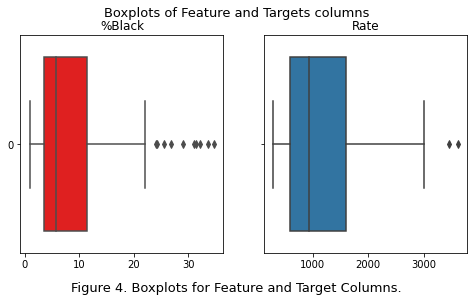

In [1120]:
# Show boxplots for predictor and target
df = NeighCovid[["Black%"]]
df['Rate'] = NeighCovid['Rate']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8,4))
sns.boxplot(data=df['Black%'], orient="h", ax=ax1, color='r')
sns.boxplot(data=df['Rate'], orient="h", ax=ax2)

# Add the figure text below
txt = 'Figure 4. Boxplots for Feature and Target Columns.'
plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=13);
ax1.set_title("%Black")
ax2.set_title("Rate")
plt.suptitle("Boxplots of Feature and Targets columns", fontsize=13);


Figure 4 shows us that there are outliers in both the feature and target columns. Let's remove the outliers and recreate the model and see if there's an improvement.

In [1121]:
# Remove outliers
from scipy import stats
# IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
# This gives us the IQR for every column

Black%       7.830000
Rate      1015.872298
dtype: float64


This code will remove all the rows that are outliers according to IQR. We call shape to determine that 11 rows have been removed. 

In [1125]:
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [1126]:
df_out.shape

(129, 2)

Let's run the model again to see if there's an improvement.

In [1139]:
# Create the X and y datasets - this time we use the dataframe with outliers removed.
X = df_out[["Black%"]]
y = df_out["Rate"]

In [1140]:
# from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [1141]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

In [1142]:
# Create and train the model
from sklearn.linear_model import LinearRegression
#Create the model :
regressor = LinearRegression()
#Train the model :
regressor.fit(X_train, y_train)

LinearRegression()

In [1143]:
y_pred = regressor.predict(X_test)

Let's look at the results of the new model. The **$R^2$ value is now 0.36**. So removing the outliers actually made things worse.

In [1146]:
from sklearn.metrics import mean_squared_error , r2_score
mse = mean_squared_error(y_test, y_pred)
# Root Mean Squared Error:
root_mse = np.sqrt(mse)
#R_squared : 
R_squared = r2_score(y_test, y_pred)
print("Intercept:              ", regressor.intercept_)
print("Root Mean Square Error: ", root_mse)
print("R^2 Value in %:              ", R_squared*100)

Intercept:               1008.2957708286475
Root Mean Square Error:  538.6686246770221
R^2 Value in %:               36.36873064381499


### Multiple Linear Regression

Now let's see if we can improve the model by using more than one feature. We will use the five features we discussed earlier: %Black, ManufactJob, Bachelor Degree, WorkNights and BothMaintHouse.

In [1149]:
# Create the X and y datasets
X = NeighCovid[['Black%', 'ManufactJob', 'BachelorDegree', 'WorkNights','BothMaintHouse']]
y = NeighCovid["Rate"]

In [1150]:
# from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [1151]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

In [1152]:
# Create and train the model
from sklearn.linear_model import LinearRegression
#Create the model :
regressor = LinearRegression()
#Train the model :
regressor.fit(X_train, y_train)

LinearRegression()

Here's the coefficient of the model:

In [1153]:
L = regressor.coef_
L[0]

243.43479434504147

Here are the coefficients for the model.

In [1154]:
# regressor.coef_
coeff_X = pd.DataFrame(regressor.coef_, index = NeighCovid.columns[:-1], columns=['Coefficient'])
coeff_X

,Coefficient
Black%,243.434794
ManufactJob,268.551318
BachelorDegree,19.125431
WorkNights,175.770549
BothMaintHouse,-47.114529


Here is the intercept:

In [1155]:
regressor.intercept_

1212.2741827886584

Here's our equation.

In [1159]:
print("Rate = {:.2f} + {:.2f}*Black% + {:.2f}*ManufactJob + {:.2f}*BachelorDegree + {:.2f}*WorkNights + \
{:.2f}*BothMaintHouse ".
      format(regressor.intercept_,L[0], L[1], L[2] ,L[3], L[4]))

Rate = 1212.27 + 243.43*Black% + 268.55*ManufactJob + 19.13*BachelorDegree + 175.77*WorkNights + -47.11*BothMaintHouse 


In [1160]:
y_pred = regressor.predict(X_test)

Let's compare the actual vs. predicted values. They don't appear to be that close.

In [1161]:
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_results.head(10)

,Actual,Predicted
97,1050.743209,669.303910
116,282.839523,481.683648
46,554.900465,936.515458
100,1064.519115,1381.808597
51,1280.614695,1516.826511
29,477.299185,642.361845
69,461.163450,283.858738
94,462.895993,873.501962
9,916.681012,502.566970
61,1530.105706,1806.311669


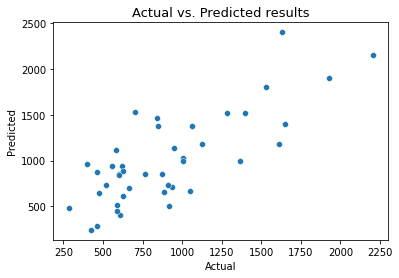

In [1162]:
# Let's examine a scatterplot of the actual vs. predicted values
sns.scatterplot(data=df_results, x = 'Actual', y = 'Predicted')
plt.title("Actual vs. Predicted results", fontsize=13);

Let's look at the results of the model. The **$R^2$ value is 0.43**. It's lower than simply using one predictor.

In [1164]:
from sklearn.metrics import mean_squared_error , r2_score

mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error:
root_mse = np.sqrt(mse)

#R_squared : 
R_squared = r2_score(y_test, y_pred)

print("Intercept:              ", regressor.intercept_)
print("Root Mean Square Error: ", root_mse)
print("R^2 Value in %:              ", R_squared*100)

Intercept:               1212.2741827886584
Root Mean Square Error:  330.03675517892543
R^2 Value in %:               43.472810980952715


We can try to remove outliers in each column but I suspect it won't help the accuracy of the model. We have already seen that Rate has outliers, the figure below also shows there are a couple outliers in BachelorDegree and ManufactJob.

Text(0.5, 1.0, 'Boxplots of each Feature showing Outliers')

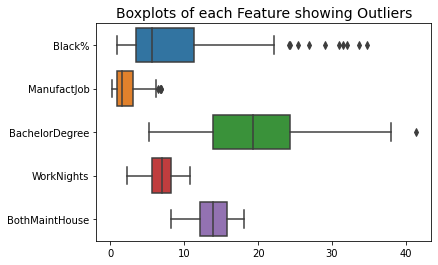

In [1202]:
# Outliers
sns.boxplot(data=NeighCovid.drop('Rate',axis=1), orient="h");
plt.title("Boxplots of the Features showing Outliers",fontsize=14);

Text(0.5, 1.0, 'Boxplot of the Target Variable showing Outliers')

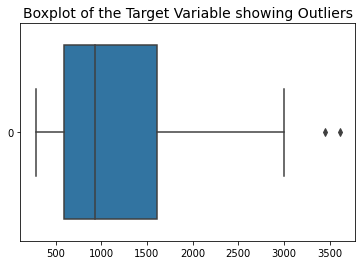

In [1203]:
sns.boxplot(data=NeighCovid['Rate'], orient="h")
plt.title("Boxplot of the Target Variable showing Outliers",fontsize=14)

In [1167]:
def RemoveOutlierDF(df):
    # Function takes a dataframe and removes all outliers
    # based in IQR
    # returns a new df
    from scipy import stats
    # IQR
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [1168]:
# Let's call the function to remove outliers
newNeighCovid = RemoveOutlierDF(NeighCovid)

In [1174]:
print(f"We removed {NeighCovid.shape[0] - newNeighCovid.shape[0]} outliers from the dataframe")

We removed 13 outliers from the dataframe


In [1197]:
def ReturnR2value(df):
    '''Accepts a dataframe returns R2 value'''
    # We assume the last column is the target
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    # Scale and fit
    sc = StandardScaler()
    X = sc.fit_transform(X)
    # Split data into train and test
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)
    # Create and train the model
    from sklearn.linear_model import LinearRegression
    #Create the model :
    regressor = LinearRegression()
    #Train the model :
    regressor.fit(X_train, y_train)
    # Predict
    y_pred = regressor.predict(X_test)
    from sklearn.metrics import mean_squared_error , r2_score

    #R_squared : 
    return round(r2_score(y_test, y_pred)*100,2)

In [1198]:
ReturnR2value(newNeighCovid)

56.82

These are very good results as the $R^2$ value has improved to almost **57%**. This is considered very good for a social science study.

### Recursive Feature Elimination (RFE)

Let's try a technique called recursive feature elimination (RFE) and see how it compares to our current model. RFE is part of the sklearn package.

RFE is described as follows: 

_Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features._ 

In [1236]:
NeighCases

,Neighbourhood ID,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2299,Col_2300,Col_2301,Col_2302,Col_2303,Col_2304,Col_2305,Neighbourhood Name,"Rate per 100,000 people",Case Count
0,129,0.44,29113.0,104.01,32.19,31.33,13.50,0.03,13.19,12.73,...,29.57,18.70,10.89,3.02,2.52,0.46,7.83,Agincourt North,838.113558,244
1,128,0.54,23757.0,92.55,35.93,34.25,12.77,0.03,12.94,14.14,...,36.94,23.61,13.24,4.13,3.20,0.93,9.13,Agincourt South-Malvern West,723.997138,172
2,20,0.17,12054.0,98.76,39.26,38.29,20.20,0.04,14.60,10.25,...,25.97,18.25,7.67,5.64,5.10,0.58,2.03,Alderwood,945.744151,114
3,95,0.31,30526.0,95.58,59.32,52.20,35.59,0.01,7.73,12.28,...,48.27,27.32,20.93,12.87,8.62,4.29,8.06,Annex,861.560637,263
4,42,0.15,27695.0,97.19,45.04,43.78,10.02,0.04,13.02,9.86,...,34.75,23.40,11.34,5.07,4.30,0.79,6.26,Banbury-Don Mills,498.284889,138
5,34,0.21,15873.0,97.23,40.43,38.36,21.28,0.03,14.65,12.22,...,37.20,23.18,14.08,5.76,4.69,1.07,8.25,Bathurst Manor,1990.801991,316
6,76,0.29,25797.0,75.00,71.47,58.43,54.65,0.01,6.57,26.59,...,70.43,24.77,45.66,20.35,12.70,7.64,25.37,Bay Street Corridor,585.339380,151
7,52,0.24,21396.0,82.59,47.26,44.55,19.61,0.02,11.29,11.71,...,52.35,28.86,23.44,9.32,6.94,2.38,14.16,Bayview Village,458.029538,98
8,49,0.37,13154.0,102.86,37.21,35.72,24.63,0.03,11.52,12.43,...,34.40,18.97,15.43,6.31,5.47,0.87,9.16,Bayview Woods-Steeles,1261.973544,166
9,39,0.17,23236.0,99.78,38.96,37.04,18.11,0.02,19.60,13.81,...,33.10,23.30,9.75,4.28,3.27,1.01,5.47,Bedford Park-Nortown,916.681012,213


In [1237]:
# Let's perform RFE on our dataset of the top 100 features. This should
# find only the necessary number of features.

# Our feat_cor contain our top 100 features
top100cols = [x for x in feat_cor.iloc[1:,:]['index']]
X = NeighCases[top100cols]
y = NeighCases['Rate per 100,000 people']

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
  True False False False  True False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False  True False False  True False False False False False False
 False False]
[59 58 61 40 23 78 57 71 41 54 33 17  1 76 25  9  1 69 35 60 85 31 53 84
 56 48 15  5 34 91 26 72 28 37 67 73 39  1 18 52 45 51 32 80  2 10 12 88
 21 36  1 66 16 75 89 87 64 81 24 68 55 50 14 74 62 13 92 79 77  6 44  8
  1 65 43  7 83 38  4 11 63 30 47 22 42 27  1  3 49  1 82 46 19 70 90 20
 86 29]


Now let's check what the RFE recommended columns are.

In [1238]:
rfe_cols = [x for x in X.columns[rfe.support_]]

In [1239]:
colNames[colNames['index'].isin(rfe_cols)]

,index,_id,Category,Topic,Special,Characteristic
330,Col_330,337,Language,Mother tongue,NaN,Akan (Twi)
332,Col_332,339,Language,Mother tongue,NaN,Edo
958,Col_958,984,Income,Income of individuals in 2015,NaN,"$20,000 to $29,999"
964,Col_964,991,Income,Income of individuals in 2015,NaN,"$20,000 to $29,999"
1170,Col_1170,1241,Immigration and citizenship,Recent immigrants by selected place of birth,NaN,Other places of birth in Americas
1190,Col_1190,1261,Immigration and citizenship,Recent immigrants by selected place of birth,NaN,Nigeria
1631,Col_1631,1707,Education,"Highest certificate, diploma or degree",NaN,Certificate of Apprenticeship or Certifi...


This is interesting. Three have to do with Education, two with languages, two with income and two with immigration.

Let's check the $R^2$ when we use these columns.

In [1242]:
rfe_df = NeighCases[rfe_cols].join(NeighCases['Rate per 100,000 people'])

In [1243]:
ReturnR2value(rfe_df)

44.81

The $R^2$ value of this model is almost **45%**. That's pretty good.

A couple features are highly correlated so lets remove those, and remove outliers and try again.

In [1245]:
rfe_df.corr()

,Col_1170,Col_1190,Col_332,Col_330,Col_1631,Col_958,Col_964,"Rate per 100,000 people"
Col_1170,1.000000,0.662406,0.784227,0.683240,0.611573,0.541691,0.541693,0.704420
Col_1190,0.662406,1.000000,0.761809,0.657477,0.334436,0.342120,0.343919,0.684025
Col_332,0.784227,0.761809,1.000000,0.870917,0.446778,0.419054,0.413849,0.657404
Col_330,0.683240,0.657477,0.870917,1.000000,0.455120,0.380258,0.374636,0.648345
Col_1631,0.611573,0.334436,0.446778,0.455120,1.000000,0.644684,0.662032,0.630197
Col_958,0.541691,0.342120,0.419054,0.380258,0.644684,1.000000,0.996086,0.618513
Col_964,0.541693,0.343919,0.413849,0.374636,0.662032,0.996086,1.000000,0.617837
"Rate per 100,000 people",0.704420,0.684025,0.657404,0.648345,0.630197,0.618513,0.617837,1.000000


In [1247]:
# Remove column 964
rfe_df.drop("Col_964", axis=1, inplace=True)

In [1249]:
# Remove outliers
NewRfeDf = RemoveOutlierDF(rfe_df)

In [1251]:
print(f"{rfe_df.shape[0] - NewRfeDf.shape[0]} columns with outliers were removed.")

30 columns with outliers were removed.


In [1252]:
ReturnR2value(NewRfeDf)

14.36

The $R^2$ has now dropped significantly to 14.36.